In [18]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import os
import sys

# sys.path.insert(0, './../style-gan/')
# import preprocessing

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.device_count()

4

# load data here

In [20]:
TRAIN_DOWNLING = '/home/rohanmirchandani/downling-examples/train/'
TEST_DOWNLING = '/home/rohanmirchandani/downling-examples/test/'

In [5]:
bs = 8

downling_test_dataloader = preprocessing.create_dataloader(TEST_DOWNLING, batch_size=bs, shrink=True)
downling_train_dataloader = preprocessing.create_dataloader(TRAIN_DOWNLING, batch_size=bs, shrink=True)

In [6]:
def display_sample_results(originals, results):
    for o, r in zip(originals, results):
        print("Input Image \n ---------------")
        plt.imshow(o.cpu().data.squeeze())
        plt.show()
        print("Output Image \n ---------------")
        plt.imshow(r.cpu().data.squeeze())
        plt.clim([0,1])
        plt.show()

# Architechture

In [7]:
class ResBlock(nn.Module):
    
    def __init__(self, n_layers, in_channels):
        super(ResBlock, self).__init__()
        
        self.n_layers = n_layers
        self.in_channels = in_channels
        
        self.elu = nn.ELU()
        
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        
        for i in range(n_layers):
            self.convs.append(nn.Conv2d(self.in_channels, self.in_channels, kernel_size=3, padding=1))
            self.bns.append(nn.BatchNorm2d(in_channels))
    
    def forward(self, x):
        
        inputs = x
        
        for i in range(self.n_layers):
            z = self.convs[i](x)
            z = self.bns[i](z)
            z = self.elu(z)
            x = z
        
        return z + inputs

In [8]:
class DownsampleBlock(nn.Module):
    
    def __init__(self, _n_channels):
        super(DownsampleBlock, self).__init__()
        self.n_channels = _n_channels
        self.elu = nn.ELU()
        self.conv1 = nn.Conv2d(self.n_channels, self.n_channels, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(self.n_channels, self.n_channels * 2, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(self.n_channels)
        self.bn2 = nn.BatchNorm2d(self.n_channels * 2)
    
    def forward(self, x):
        z = self.conv1(x)
        z = self.bn1(z)
        z = self.elu(z)
        z = self.conv2(z)
        z = self.bn2(z)
        z = self.elu(z)
        return z
    

In [9]:
class UpsampleBlock(nn.Module):
    
    def __init__(self, n_channels, scale_factor=2, mode='nearest', shrink_channels=True):
        super(UpsampleBlock, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.n_channels = n_channels
        self.out_channels = int(self.n_channels / 2) if shrink_channels else self.n_channels
        print(self.out_channels)
        self.conv1 = nn.Conv2d(self.n_channels, self.n_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(self.n_channels, self.out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(self.n_channels)        
        self.bn2 = nn.BatchNorm2d(self.out_channels)
        self.elu = nn.ELU()
    
    def forward(self, x):
        z = F.upsample(x, scale_factor=self.scale_factor, mode=self.mode)
        z = self.conv1(z)
        z = self.bn1(z)
        z = self.elu(z)
        z = self.conv2(z)
        z = self.bn2(z)
        z = self.elu(z)
        return z


In [66]:
class ResEncoder(nn.Module):
    
    def __init__(self, nc, nef, ls):
        super(ResEncoder, self).__init__()
        
        self.nc = nc
        self.nef = nef
        self.ls = ls
        
        self.conv1 = nn.Conv2d(self.nc, self.nef, kernel_size=3, padding=1)
        
        self.res1 = ResBlock(3, self.nef)
        self.res2 = ResBlock(3, self.nef * 2)
        self.res3 = ResBlock(3, self.nef * 4)
        self.res4 = ResBlock(3, self.nef * 8)
        self.res5 = ResBlock(3, self.nef * 16)
        self.res6 = ResBlock(3, self.nef * 32)
        
        self.conv_mu = nn.Conv2d(self.nef * 64, self.ls, kernel_size=4)
        self.conv_logvar = nn.Conv2d(self.nef * 64, self.ls, kernel_size=4)
        self.raw_out = nn.Conv2d(self.nef * 64, self.ls, kernel_size=4)
        
        self.down1 = DownsampleBlock(self.nef) 
        self.down2 = DownsampleBlock(self.nef * 2)
        self.down3 = DownsampleBlock(self.nef * 4)
        self.down4 = DownsampleBlock(self.nef * 8)
        self.down5 = DownsampleBlock(self.nef * 16)
        self.down6 = DownsampleBlock(self.nef * 32)
    
    def forward(self, x):
        z = self.conv1(x) # 16 x 256 x 256
        z = self.res1(z)# 16 x 256 x 256
        z = self.down1(z) # 32 x 128 x 128
        z = self.res2(z) # 32 x 128 x 128
        z = self.down2(z) # 64 * 64 * 64
        z = self.res3(z) # 64 * 64 * 64
        z = self.down3(z) # 128 x 32 x 32
        z = self.res4(z) # 128 * 32 * 32
        z = self.down4(z) # 256 x 16 x 16
        z = self.res5(z) # 256 x 16 x 16
        z = self.down5(z) # 512 x 8 x 8
        z = self.res6(z) # 512 x 8 x 8
        z = self.down6(z) # 1024 x 4 x 4
#         mu = self.conv_mu(z)
#         logvar = self.conv_logvar(z)
        z = self.raw_out(z)
#         return mu, logvar
        return z
    

In [67]:
class ResDecoder(nn.Module):
    
    def __init__(self, nc, nef, oc):
        super(ResDecoder, self).__init__()
        
        self.nc = nc
        self.nef = nef
        self.oc = oc
        
        self.conv1 = nn.Conv2d(self.nef * 2, self.oc, kernel_size=1)
        
        self.res1 = ResBlock(3, self.nef * 64)
        self.res2 = ResBlock(3, self.nef * 64)
        self.res3 = ResBlock(3, self.nef * 32)
        self.res4 = ResBlock(3, self.nef * 16)
        self.res5 = ResBlock(3, self.nef * 8)
        self.res6 = ResBlock(3, self.nef * 4)
        self.res7 = ResBlock(3, self.nef * 2)
        
        self.upsample1 = UpsampleBlock(self.nef * 64, shrink_channels=False)
        self.upsample2 = UpsampleBlock(self.nef * 64, shrink_channels=False)
        self.upsample3 = UpsampleBlock(self.nef * 64)
        self.upsample4 = UpsampleBlock(self.nef * 32)
        self.upsample5 = UpsampleBlock(self.nef * 16)
        self.upsample6 = UpsampleBlock(self.nef * 8)
        self.upsample7 = UpsampleBlock(self.nef * 4)
        self.upsample8 = UpsampleBlock(self.nef * 2, shrink_channels=False)

    def forward(self, x):
        z = self.upsample1(x) # 1024 x 2 x 2
        z = self.res1(z)
        z = self.upsample2(z) # 1024 x 4 x 4
        z = self.res2(z)
        z = self.upsample3(z) # 512 x 8 x 8
        z = self.res3(z)
        z = self.upsample4(z) # 256 x 16 x 16
        z = self.res4(z)
        z = self.upsample5(z) # 128 x 32 x 32
        z = self.res5(z)
        z = self.upsample6(z) # 64 x 64 x 64
        z = self.res6(z)
        z = self.upsample7(z) # 32 x 128 x 128
#         z = self.res7(z)
        z = self.upsample8(z) # 16 x 256 x 256
        z = self.conv1(z) # 1 x 256 x 256
        return F.sigmoid(z)
        

In [68]:
def reparameterise(mu, logvar):
    std = logvar.mul(0.5).exp_()
    eps = Variable(std.data.new(std.size()).normal_())
    return eps.mul(std).add_(mu)


# Train

1024
1024
512
256
128
64
32
32
Epoch 0

 0.1318
[torch.cuda.FloatTensor of size () (GPU 0)]



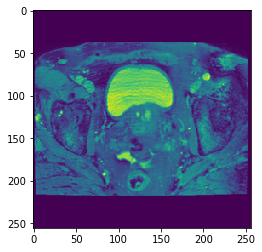

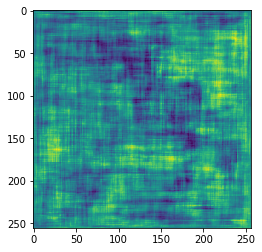


1.00000e-02 *
  9.4018
[torch.cuda.FloatTensor of size () (GPU 0)]



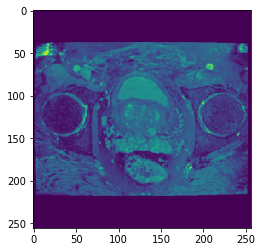

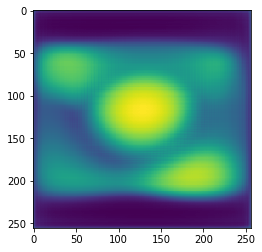


 0.1003
[torch.cuda.FloatTensor of size () (GPU 0)]



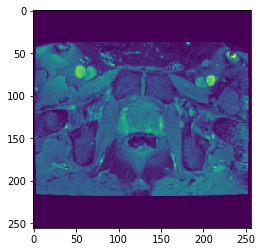

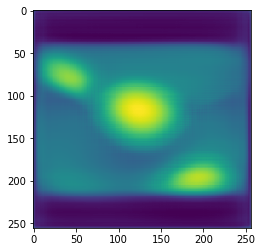


1.00000e-02 *
  9.0280
[torch.cuda.FloatTensor of size () (GPU 0)]



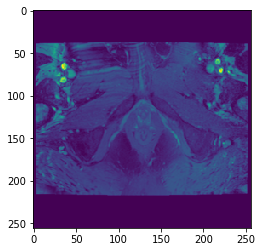

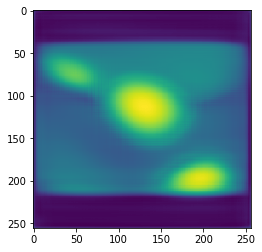


1.00000e-02 *
  7.8813
[torch.cuda.FloatTensor of size () (GPU 0)]



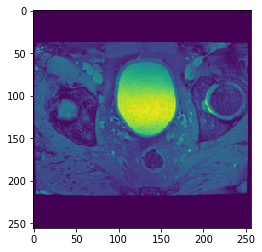

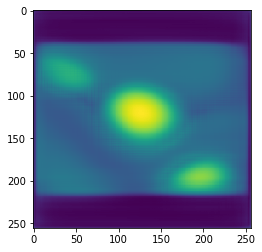


1.00000e-02 *
  6.6270
[torch.cuda.FloatTensor of size () (GPU 0)]



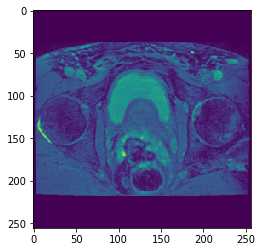

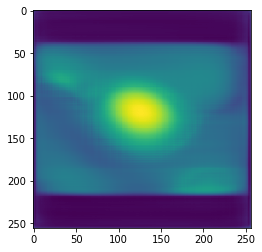


1.00000e-02 *
  5.8057
[torch.cuda.FloatTensor of size () (GPU 0)]



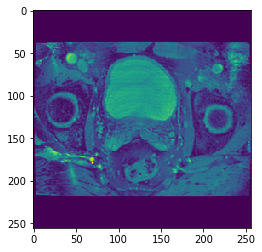

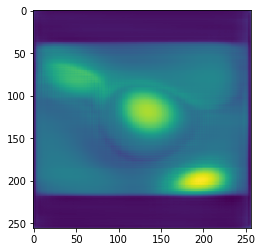


1.00000e-02 *
  6.0570
[torch.cuda.FloatTensor of size () (GPU 0)]



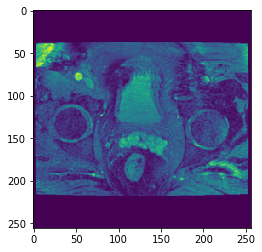

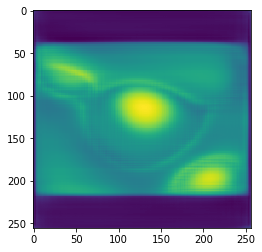


1.00000e-02 *
  4.7017
[torch.cuda.FloatTensor of size () (GPU 0)]



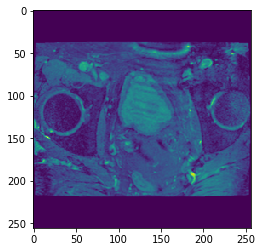

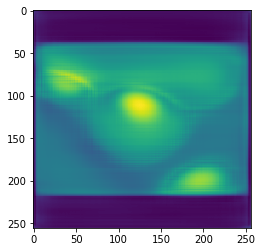


1.00000e-02 *
  4.0637
[torch.cuda.FloatTensor of size () (GPU 0)]



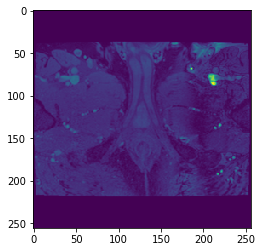

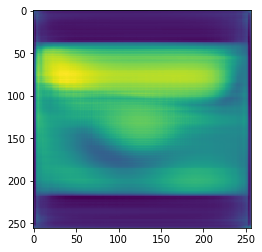


1.00000e-02 *
  4.3203
[torch.cuda.FloatTensor of size () (GPU 0)]



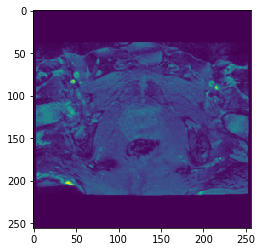

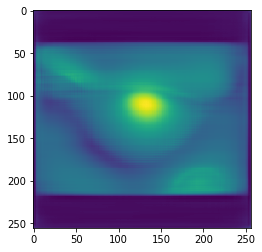


1.00000e-02 *
  3.7579
[torch.cuda.FloatTensor of size () (GPU 0)]



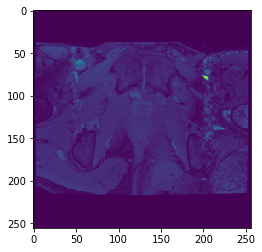

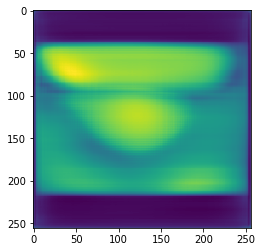

Process Process-183:
Traceback (most recent call last):
Process Process-182:
Process Process-180:
Process Process-181:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-179:
Process Process-177:
Process Process-178:
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-184:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/

KeyboardInterrupt: 

  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt


In [69]:
epochs = 20

original_channels = 1
growth_rate = 16
latent_size = growth_rate * 64

beta = 1

E = nn.DataParallel(ResEncoder(original_channels, growth_rate, latent_size).cuda())
D = nn.DataParallel(ResDecoder(latent_size, growth_rate, original_channels).cuda())

criterion = nn.MSELoss()

opt_params = list(E.parameters()) + list(D.parameters())
opt = optim.Adam(opt_params, lr=3e-4)

for epoch in range(epochs):
    
    print('Epoch {}'.format(epoch))
    
    for i, batch in enumerate(downling_train_dataloader):
        opt.zero_grad() 
        inputs = Variable(batch['img'])
#         mu, logvar = E(inputs)
        latent_sample = E(inputs)
#         mu = mu.squeeze()
#         logvar = logvar.squeeze()
#         kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#         latent_sample = reparameterise(mu, logvar)
#         latent_sample = latent_sample.unsqueeze(2).unsqueeze(3)
        result = D(latent_sample)
        mse_loss = criterion(result, inputs.cuda())
        loss = mse_loss #+ kld_loss * beta
        loss.backward()
        opt.step()
        
        if i % 30 == 0:
            print(mse_loss)
            img = inputs[0].cpu().data
            plt.imshow(img.squeeze())
            plt.show()
            img = result[0].cpu().data
            plt.imshow(img.squeeze())
            plt.show()